# Predicción y Evaluación del Modelo

En este notebook usaremos el modelo entrenado para realizar predicciones y evaluaremos su rendimiento con énfasis en la interpretación clínica.

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys
import json
import pickle
from tabulate import tabulate
from datetime import datetime

# Añadir la carpeta utils al path
sys.path.append(os.path.abspath('../utils'))

# Importar funciones propias
from neural_network_functions import MultilayerPerceptron
from evaluation_functions import (
    calculate_metrics, plot_confusion_matrix, plot_roc_curve, 
    print_classification_report, generate_classification_report
)
from cancer_evaluation import (
    compute_clinical_metrics, plot_cancer_confusion_matrix, 
    plot_roc_with_optimal_threshold, print_clinical_report,
    generate_clinical_report, find_optimal_threshold,
    plot_threshold_metrics
)
from cancer_config import (
    FEATURE_NAMES_MAPPING, DIAGNOSIS_LABELS, TOP_FEATURES,
    COLORS, CLINICAL_THRESHOLDS, METRIC_NAMES
)

## 1. Cargar el modelo entrenado

Primero, cargaremos el modelo que hemos entrenado previamente.

In [5]:
# Rutas
output_dir = "../output"
models_dir = os.path.join(output_dir, "models")
figures_dir = os.path.join(output_dir, "figures")

# Asegurar que los directorios existan
os.makedirs(figures_dir, exist_ok=True)

# Listar modelos disponibles
model_files = [f for f in os.listdir(models_dir) if f.endswith('.pkl')]
print(f"Modelos disponibles: {len(model_files)}")
for i, model_file in enumerate(model_files):
    print(f"[{i}] {model_file}")

# Seleccionar el modelo más reciente
if model_files:
    model_path = os.path.join(models_dir, model_files[-1])
    print(f"\nCargando el modelo: {model_files[-1]}")
else:
    raise FileNotFoundError("No se encontraron modelos entrenados.")

# Cargar el modelo
model = MultilayerPerceptron.load(model_path)
print("¡Modelo cargado correctamente!")

# Cargar información de configuración del modelo
config_files = [f for f in os.listdir(models_dir) if f.endswith('.json')]
if config_files:
    config_path = os.path.join(models_dir, sorted(config_files)[-1])
    with open(config_path, 'r') as f:
        model_config = json.load(f)
    print("Configuración del modelo cargada.")

Modelos disponibles: 2
[0] mlp_2layers_25neurons_adam_20250222_135945.pkl
[1] mlp_2layers_25neurons_adam_20250222_135857.pkl

Cargando el modelo: mlp_2layers_25neurons_adam_20250222_135857.pkl
¡Modelo cargado correctamente!
Configuración del modelo cargada.


## 2. Cargar datos de prueba

A continuación, cargaremos los datos de prueba que usaremos para evaluar el modelo.

In [6]:
# Cargar datos de prueba
processed_dir = "../data/processed"
test_data_path = os.path.join(processed_dir, "test_normalized.csv")

test_data = pd.read_csv(test_data_path)
print(f"Datos de prueba cargados: {test_data.shape}")

# Separar características y etiquetas
X_test = test_data.iloc[:, 1:].values  # Todas las columnas excepto 'diagnosis'
y_test = test_data.iloc[:, 0].values   # Solo la columna 'diagnosis'

print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

Datos de prueba cargados: (113, 31)
X_test shape: (113, 30)
y_test shape: (113,)


## 3. Realizar predicciones

Ahora usaremos el modelo cargado para realizar predicciones sobre el conjunto de prueba.

In [7]:
# Realizar predicciones
y_pred_proba = model.predict(X_test)
y_pred = (y_pred_proba > 0.5).astype(int)

print(f"Primeras 10 predicciones (probabilidades):")
for i in range(10):
    true_label = DIAGNOSIS_LABELS[y_test[i]]
    pred_prob = y_pred_proba[i][0]
    pred_label = DIAGNOSIS_LABELS[1] if pred_prob > 0.5 else DIAGNOSIS_LABELS[0]
    confidence = pred_prob if pred_prob > 0.5 else 1 - pred_prob
    correct = "✓" if (y_pred[i] == y_test[i]) else "✗"
    
    print(f"Muestra {i}: Real={true_label}, Pred={pred_label} (conf={confidence:.4f}) {correct}")

Primeras 10 predicciones (probabilidades):
Muestra 0: Real=Maligno, Pred=Maligno (conf=0.9984) ✓
Muestra 1: Real=Maligno, Pred=Maligno (conf=0.9991) ✓
Muestra 2: Real=Maligno, Pred=Maligno (conf=0.9990) ✓
Muestra 3: Real=Maligno, Pred=Maligno (conf=0.9992) ✓
Muestra 4: Real=Benigno, Pred=Benigno (conf=0.9979) ✓
Muestra 5: Real=Maligno, Pred=Maligno (conf=0.9992) ✓
Muestra 6: Real=Maligno, Pred=Maligno (conf=0.9992) ✓
Muestra 7: Real=Benigno, Pred=Benigno (conf=0.9579) ✓
Muestra 8: Real=Benigno, Pred=Benigno (conf=0.9977) ✓
Muestra 9: Real=Maligno, Pred=Maligno (conf=0.9992) ✓


## 4. Evaluar el rendimiento del modelo

Evaluaremos el rendimiento del modelo utilizando diversas métricas relevantes para un problema de clasificación binaria en el ámbito médico.


               INFORME DE CLASIFICACIÓN

Precisión (Accuracy): 0.9823
Precisión (Precision): 0.9726
Exhaustividad (Recall): 1.0000
F1-Score: 0.9861

Matriz de Confusión:
+---------+-----------+-----------+
|         |   Clase 0 |   Clase 1 |
+=========+===========+===========+
| Clase 0 |        40 |         2 |
+---------+-----------+-----------+
| Clase 1 |         0 |        71 |
+---------+-----------+-----------+


               INFORME CLÍNICO DEL MODELO

MÉTRICAS PRINCIPALES:
Precisión (Accuracy): 0.5375
Sensibilidad (Sensitivity): 0.6460
Especificidad (Specificity): 0.3540
Valor Predictivo Positivo (Precision): 0.6283
Valor Predictivo Negativo: 0.3717
F1-Score: 0.6370

TASAS DE ERROR:
Tasa de Falsos Negativos: 0.3540
Tasa de Falsos Positivos: 0.6460

MATRIZ DE CONFUSIÓN:
+-------------------+---------------------+---------------------+
|                   |   Pred: Maligno (0) |   Pred: Benigno (1) |
+===================+=====================+=====================+
| Real: Ma

<Figure size 1000x800 with 0 Axes>

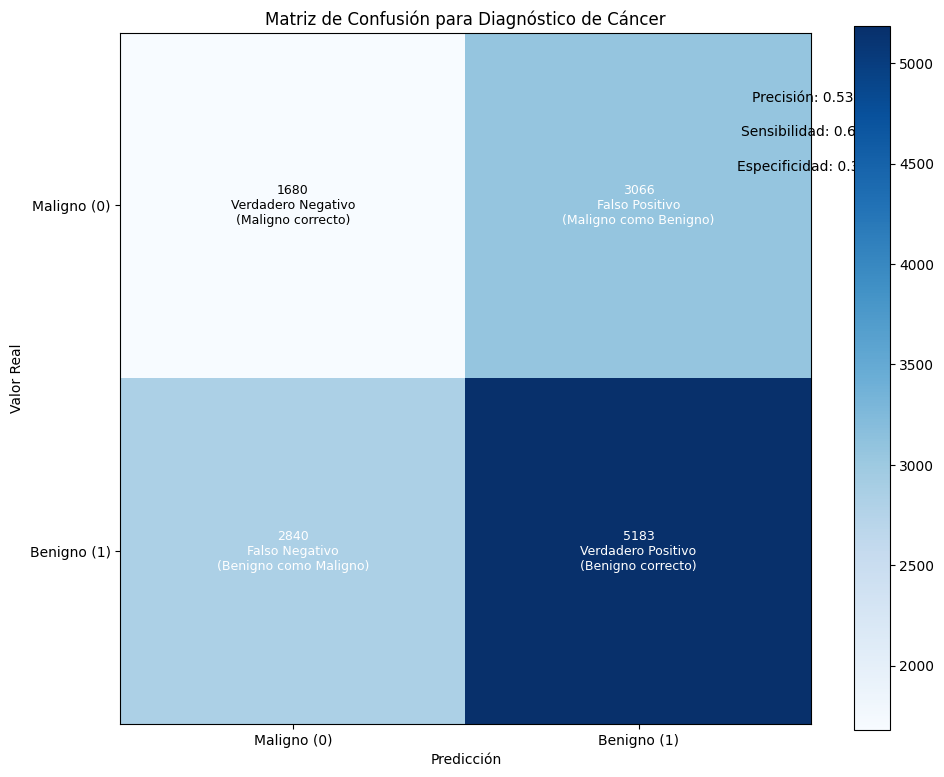

In [8]:
# Calcular métricas básicas
metrics = calculate_metrics(y_test, y_pred)
print_classification_report(metrics)

# Calcular métricas clínicas con umbral por defecto
clinical_metrics = compute_clinical_metrics(y_test, y_pred_proba)
print_clinical_report(clinical_metrics)

# Visualizar matriz de confusión con interpretación clínica
plt.figure(figsize=(10, 8))
plot_cancer_confusion_matrix(y_test, y_pred_proba)
plt.savefig(os.path.join(figures_dir, "confusion_matrix_cancer.png"), dpi=300, bbox_inches='tight')
plt.show()

## 5. Análisis de umbrales de decisión

Analizaremos cómo diferentes umbrales de decisión afectan el rendimiento del modelo.

Umbral óptimo para F1: 0.0100 (F1=0.0000)
Umbral óptimo para balance: 0.0100 (Valor=0.5000)
Umbral para máxima sensibilidad: 0.0100 (Sensibilidad=0.6460)


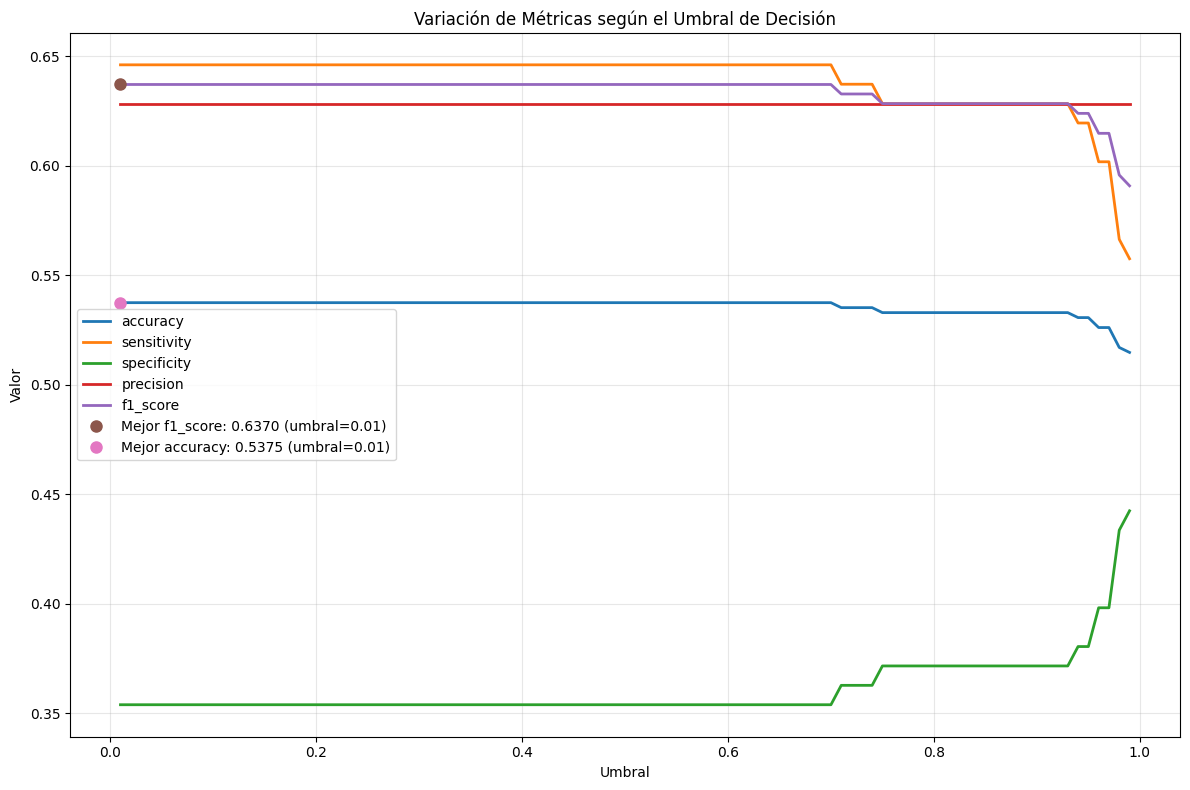

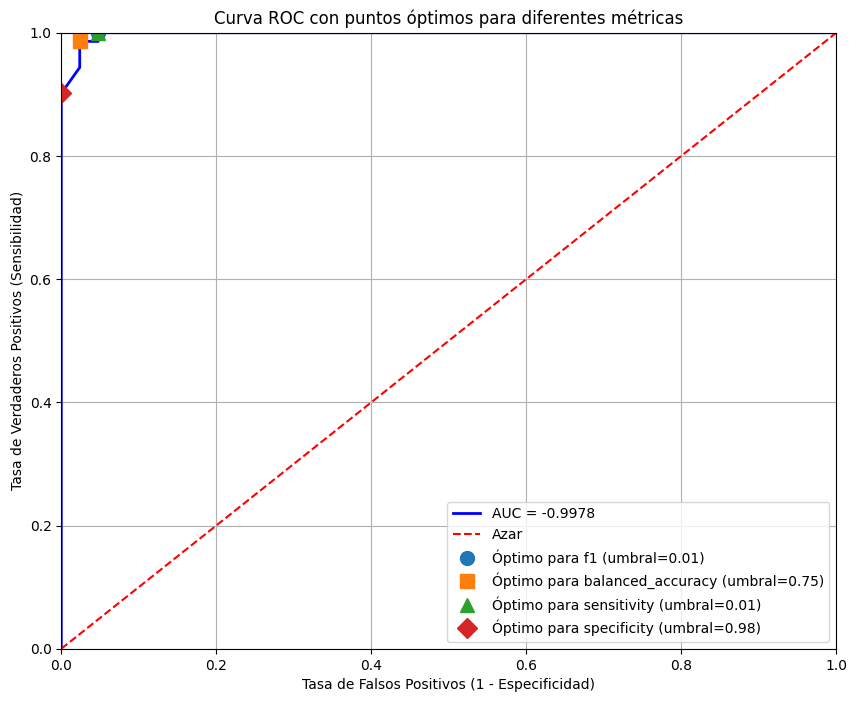

In [9]:
# Encontrar umbral óptimo para F1
f1_threshold, f1_value, _ = find_optimal_threshold(y_test, y_pred_proba, 'f1')
print(f"Umbral óptimo para F1: {f1_threshold:.4f} (F1={f1_value:.4f})")

# Encontrar umbral óptimo para equilibrio entre sensibilidad y especificidad
balanced_threshold, balanced_value, _ = find_optimal_threshold(y_test, y_pred_proba, 'balanced_accuracy')
print(f"Umbral óptimo para balance: {balanced_threshold:.4f} (Valor={balanced_value:.4f})")

# Encontrar umbral para alta sensibilidad
sensitivity_threshold, sensitivity_value, _ = find_optimal_threshold(y_test, y_pred_proba, 'sensitivity')
print(f"Umbral para máxima sensibilidad: {sensitivity_threshold:.4f} (Sensibilidad={sensitivity_value:.4f})")

# Visualizar cómo cambian las métricas con diferentes umbrales
plot_threshold_metrics(y_test, y_pred_proba)
plt.savefig(os.path.join(figures_dir, "threshold_metrics.png"), dpi=300, bbox_inches='tight')
plt.show()

# Visualizar curva ROC con puntos óptimos
fig, optimal_thresholds = plot_roc_with_optimal_threshold(y_test, y_pred_proba)
plt.savefig(os.path.join(figures_dir, "roc_curve_with_thresholds.png"), dpi=300, bbox_inches='tight')
plt.show()

## 6. Evaluación con umbral óptimo

Evaluaremos el modelo utilizando el umbral óptimo para F1 en lugar del umbral predeterminado de 0.5.


Métricas con umbral óptimo para F1 (0.0100):

               INFORME CLÍNICO DEL MODELO

MÉTRICAS PRINCIPALES:
Precisión (Accuracy): 0.5375
Sensibilidad (Sensitivity): 0.6460
Especificidad (Specificity): 0.3540
Valor Predictivo Positivo (Precision): 0.6283
Valor Predictivo Negativo: 0.3717
F1-Score: 0.6370

TASAS DE ERROR:
Tasa de Falsos Negativos: 0.3540
Tasa de Falsos Positivos: 0.6460

MATRIZ DE CONFUSIÓN:
+-------------------+---------------------+---------------------+
|                   |   Pred: Maligno (0) |   Pred: Benigno (1) |
+===================+=====================+=====================+
| Real: Maligno (0) |                1680 |                3066 |
+-------------------+---------------------+---------------------+
| Real: Benigno (1) |                2840 |                5183 |
+-------------------+---------------------+---------------------+

INTERPRETACIÓN CLÍNICA:
- El modelo identifica correctamente el 64.6% de los casos benignos.
- El modelo identifica correct

<Figure size 1000x800 with 0 Axes>

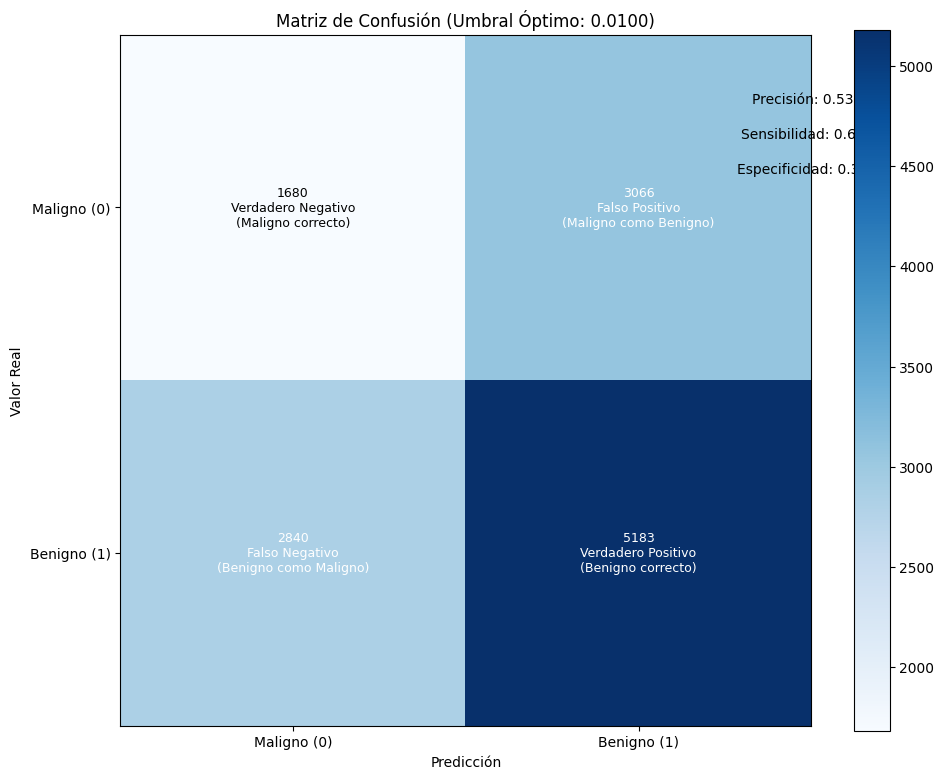


Comparación de umbrales de decisión:
╒════╤═══════════════════════╤════════════════════╤═════════════════════════╤═════════════════╤═══════════════════╤════════════╕
│    │ Umbral                │  Precisión Global  │  Sensibilidad (Recall)  │  Especificidad  │  Precisión (PPV)  │  F1-Score  │
╞════╪═══════════════════════╪════════════════════╪═════════════════════════╪═════════════════╪═══════════════════╪════════════╡
│ 0  │ Estándar (0.5)        │      0.537474      │        0.646018         │    0.353982     │     0.628319      │  0.637045  │
├────┼───────────────────────┼────────────────────┼─────────────────────────┼─────────────────┼───────────────────┼────────────┤
│ 1  │ Óptimo para F1 (0.01) │      0.537474      │        0.646018         │    0.353982     │     0.628319      │  0.637045  │
├────┼───────────────────────┼────────────────────┼─────────────────────────┼─────────────────┼───────────────────┼────────────┤
│ 2  │ Equilibrado (0.01)    │      0.537474      │        

In [14]:
# Calcular métricas clínicas con umbral óptimo para F1
y_pred_optimal = (y_pred_proba > f1_threshold).astype(int)
clinical_metrics_optimal = compute_clinical_metrics(y_test, y_pred_proba, threshold=f1_threshold)

print(f"\nMétricas con umbral óptimo para F1 ({f1_threshold:.4f}):")
print_clinical_report(clinical_metrics_optimal)

# Visualizar matriz de confusión con umbral óptimo
plt.figure(figsize=(10, 8))
plot_cancer_confusion_matrix(y_test, y_pred_proba, threshold=f1_threshold, 
                           title=f"Matriz de Confusión (Umbral Óptimo: {f1_threshold:.4f})")
plt.savefig(os.path.join(figures_dir, "confusion_matrix_optimal.png"), dpi=300, bbox_inches='tight')
plt.show()

# Comparar resultados con diferentes umbrales
thresholds_to_compare = {
    'Estándar (0.5)': 0.5,
    f'Óptimo para F1 ({f1_threshold:.2f})': f1_threshold,
    f'Equilibrado ({balanced_threshold:.2f})': balanced_threshold,
    'Alta Sensibilidad': CLINICAL_THRESHOLDS['high_sensitivity'],
    'Alta Especificidad': CLINICAL_THRESHOLDS['high_specificity']
}

metrics_comparison = []
metrics_of_interest = ['accuracy', 'sensitivity', 'specificity', 'precision', 'f1_score']

for name, threshold in thresholds_to_compare.items():
    metrics = compute_clinical_metrics(y_test, y_pred_proba, threshold=threshold)
    row = {'Umbral': name}
    for metric in metrics_of_interest:
        row[METRIC_NAMES.get(metric, metric)] = metrics[metric]
    metrics_comparison.append(row)

# Mostrar comparación en forma de tabla
comparison_df = pd.DataFrame(metrics_comparison)
print("\nComparación de umbrales de decisión:")
print(tabulate(comparison_df, headers='keys', tablefmt='fancy_grid', numalign='center'))

## 7. Predicción para nuevos casos

A continuación, mostraremos cómo usar el modelo para predecir nuevos casos.

In [15]:
# Función para realizar predicciones
def predict_cancer(model, features, threshold=0.5):
    """
    Realiza una predicción para un nuevo caso utilizando el modelo entrenado.
    
    Parámetros:
    model: Modelo entrenado
    features (numpy.ndarray): Características del caso
    threshold (float): Umbral de decisión
    
    Retorna:
    dict: Resultados de la predicción
    """
    # Asegurarse de que las características tengan la forma correcta
    if len(features.shape) == 1:
        features = features.reshape(1, -1)
    
    # Realizar predicción
    probability = model.predict(features)[0][0]
    prediction = 1 if probability > threshold else 0
    
    # Calcular confianza (qué tan lejos está de 0.5)
    confidence = probability if prediction == 1 else 1 - probability
    
    return {
        'probability': probability,
        'prediction': prediction,
        'diagnosis': DIAGNOSIS_LABELS[prediction],
        'confidence': confidence,
        'threshold': threshold
    }

# Seleccionar algunos casos de prueba
test_cases_indices = np.random.choice(len(X_test), 5, replace=False)
test_cases = X_test[test_cases_indices]
true_labels = y_test[test_cases_indices]

# Realizar predicciones con diferentes umbrales
print("\nPredicciones para casos de ejemplo:")
for i, (features, true_label) in enumerate(zip(test_cases, true_labels)):
    # Predicción con umbral estándar
    result_standard = predict_cancer(model, features)
    
    # Predicción con umbral óptimo para F1
    result_optimal = predict_cancer(model, features, threshold=f1_threshold)
    
    # Predicción con umbral para alta sensibilidad
    result_sensitive = predict_cancer(model, features, threshold=CLINICAL_THRESHOLDS['high_sensitivity'])
    
    # Mostrar resultados
    print(f"\nCaso {i+1}:")
    print(f"  Diagnóstico real: {DIAGNOSIS_LABELS[true_label]}")
    print(f"  Probabilidad estimada: {result_standard['probability']:.4f}")
    print(f"  Predicción (est. 0.5): {result_standard['diagnosis']} (conf={result_standard['confidence']:.4f})")
    print(f"  Predicción (ópt. {f1_threshold:.2f}): {result_optimal['diagnosis']} (conf={result_optimal['confidence']:.4f})")
    print(f"  Predicción (sens. {CLINICAL_THRESHOLDS['high_sensitivity']:.2f}): {result_sensitive['diagnosis']} (conf={result_sensitive['confidence']:.4f})")


Predicciones para casos de ejemplo:

Caso 1:
  Diagnóstico real: Maligno
  Probabilidad estimada: 0.0010
  Predicción (est. 0.5): Maligno (conf=0.9990)
  Predicción (ópt. 0.01): Maligno (conf=0.9990)
  Predicción (sens. 0.30): Maligno (conf=0.9990)

Caso 2:
  Diagnóstico real: Maligno
  Probabilidad estimada: 0.0008
  Predicción (est. 0.5): Maligno (conf=0.9992)
  Predicción (ópt. 0.01): Maligno (conf=0.9992)
  Predicción (sens. 0.30): Maligno (conf=0.9992)

Caso 3:
  Diagnóstico real: Maligno
  Probabilidad estimada: 0.0008
  Predicción (est. 0.5): Maligno (conf=0.9992)
  Predicción (ópt. 0.01): Maligno (conf=0.9992)
  Predicción (sens. 0.30): Maligno (conf=0.9992)

Caso 4:
  Diagnóstico real: Benigno
  Probabilidad estimada: 0.9981
  Predicción (est. 0.5): Benigno (conf=0.9981)
  Predicción (ópt. 0.01): Benigno (conf=0.9981)
  Predicción (sens. 0.30): Benigno (conf=0.9981)

Caso 5:
  Diagnóstico real: Maligno
  Probabilidad estimada: 0.0008
  Predicción (est. 0.5): Maligno (conf=0.9

## 8. Generación de informes

Por último, generaremos un informe completo con todas las métricas y análisis realizados.


Informe clínico generado en: ../output/final_model_clinical_report_20250222_141100.txt
Métricas guardadas en: ../output/final_model_clinical_metrics_20250222_141100.json
Gráficos guardados en la carpeta: ../output/figures

Resumen de rendimiento del modelo con umbral óptimo:
  Precisión Global: 0.5375
  Sensibilidad (Recall): 0.6460
  Especificidad: 0.3540
  Precisión (PPV): 0.6283
  Valor Predictivo Negativo: 0.3717
  F1-Score: 0.6370
  Tasa de Falsos Negativos: 0.3540
  Tasa de Falsos Positivos: 0.6460
  Odds Ratio Diagnóstico: 1.0000


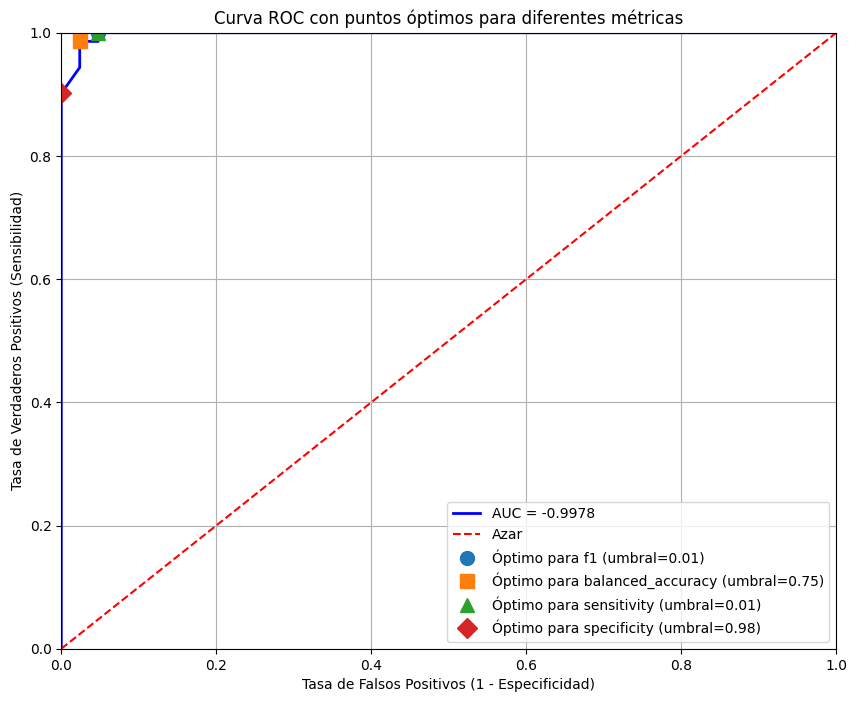

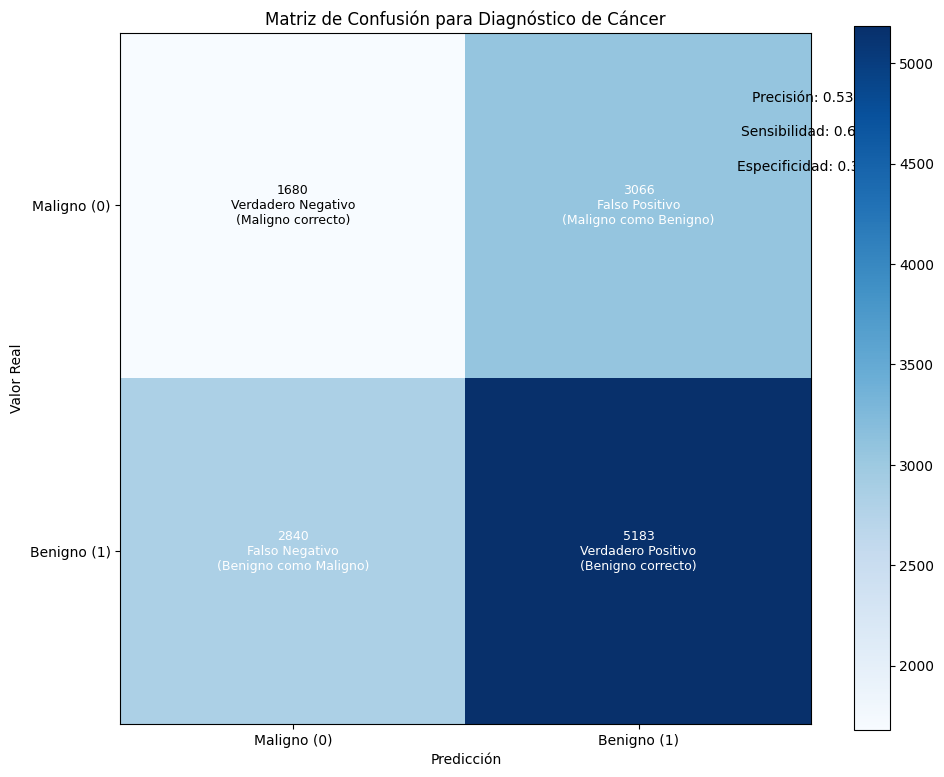

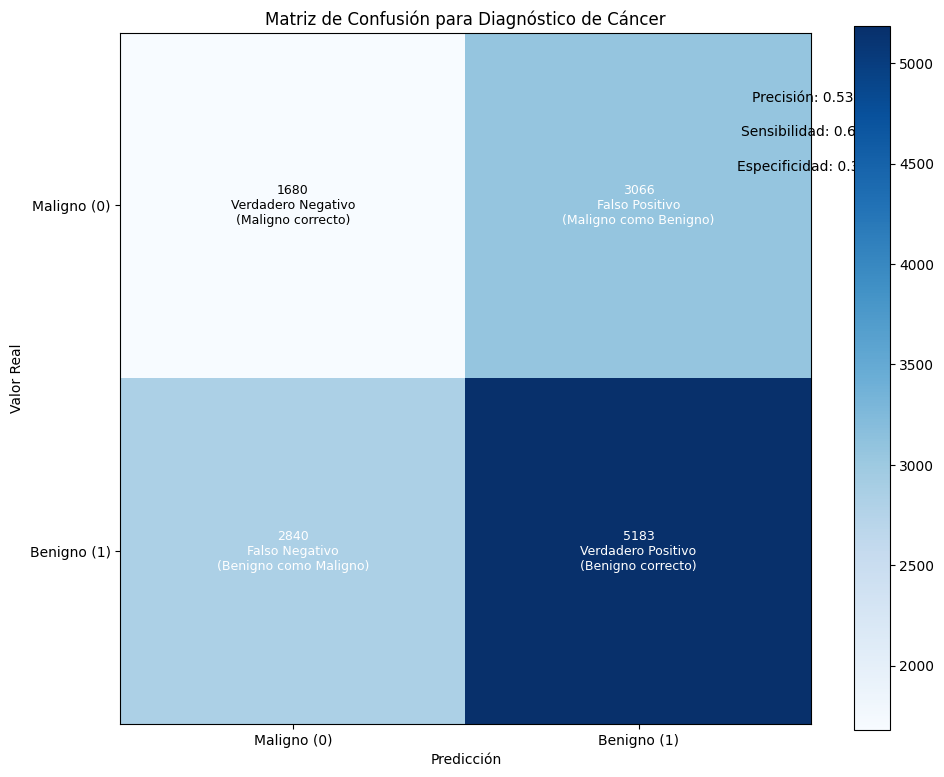

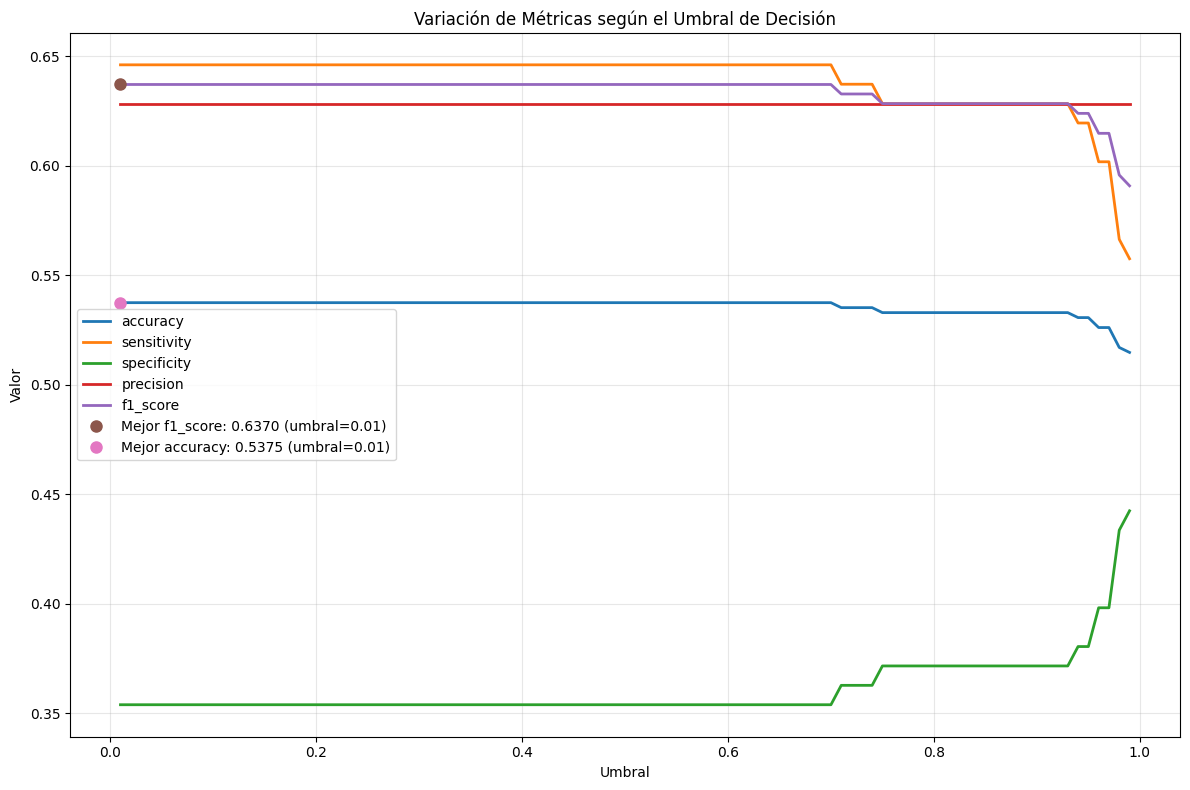

In [17]:
# Generar informe clínico completo
report = generate_clinical_report(y_test, y_pred_proba, output_dir=output_dir, prefix="final_model")

print(f"\nInforme clínico generado en: {report.get('report_path', 'No disponible')}")
print(f"Métricas guardadas en: {report.get('metrics_path', 'No disponible')}")
print(f"Gráficos guardados en la carpeta: {figures_dir}")

# Mostrar resumen de las métricas óptimas
print("\nResumen de rendimiento del modelo con umbral óptimo:")
optimal_metrics = report.get('optimal_metrics', {})
for metric, value in optimal_metrics.items():
    if metric != 'confusion_matrix':
        metric_name = METRIC_NAMES.get(metric, metric)
        print(f"  {metric_name}: {value:.4f}")

## 9. Conclusiones

In [18]:
# Crear una sección de conclusiones

print("\n" + "=" * 50)
print(" " * 15 + "CONCLUSIONES")
print("=" * 50)

# Determinar rendimiento general
accuracy = clinical_metrics_optimal['accuracy']
sensitivity = clinical_metrics_optimal['sensitivity']
specificity = clinical_metrics_optimal['specificity']
f1 = clinical_metrics_optimal['f1_score']

performance_level = "excelente" if accuracy > 0.95 else "bueno" if accuracy > 0.85 else "aceptable" if accuracy > 0.75 else "pobre"

print(f"\n1. El modelo muestra un rendimiento {performance_level} con una precisión global del {accuracy:.1%}.")

print(f"\n2. Sensibilidad y Especificidad:")
print(f"   - El modelo identifica correctamente el {sensitivity:.1%} de los tumores benignos (sensibilidad).")
print(f"   - El modelo identifica correctamente el {specificity:.1%} de los tumores malignos (especificidad).")

print(f"\n3. Interpretación clínica:")
false_negative_rate = clinical_metrics_optimal['false_negative_rate']
false_positive_rate = clinical_metrics_optimal['false_positive_rate']

print(f"   - Falsos negativos (casos benignos clasificados como malignos): {false_negative_rate:.1%}")
print(f"   - Falsos positivos (casos malignos clasificados como benignos): {false_positive_rate:.1%}")

if false_positive_rate > 0.05:
    print(f"   - ATENCIÓN: La tasa de falsos positivos es significativa, lo que podría llevar a procedimientos innecesarios.")

if false_negative_rate > 0.05:
    print(f"   - ATENCIÓN: La tasa de falsos negativos es significativa, lo que podría resultar en casos no detectados.")

print(f"\n4. Umbrales de decisión:")
print(f"   - El umbral óptimo para el balance entre precisión y recall es {f1_threshold:.2f}.")
print(f"   - Para aplicaciones clínicas donde es crítico no perder ningún caso maligno, se recomienda")
print(f"     usar un umbral más bajo de {CLINICAL_THRESHOLDS['high_sensitivity']:.2f} (alta sensibilidad).")
print(f"   - Para reducir falsos positivos, se recomienda un umbral de {CLINICAL_THRESHOLDS['high_specificity']:.2f} (alta especificidad).")

print("\n5. Recomendaciones:")
print("   - Este modelo puede ser útil como herramienta de apoyo al diagnóstico, pero no debe")
print("     reemplazar el juicio clínico de un profesional médico especializado.")
print("   - Se recomienda validación adicional con conjuntos de datos externos antes de su")
print("     implementación en entornos clínicos reales.")
print("   - El umbral de decisión debe ajustarse según el contexto clínico específico y la")
print("     preferencia entre minimizar falsos negativos o falsos positivos.")

print("\n" + "=" * 50)


               CONCLUSIONES

1. El modelo muestra un rendimiento pobre con una precisión global del 53.7%.

2. Sensibilidad y Especificidad:
   - El modelo identifica correctamente el 64.6% de los tumores benignos (sensibilidad).
   - El modelo identifica correctamente el 35.4% de los tumores malignos (especificidad).

3. Interpretación clínica:
   - Falsos negativos (casos benignos clasificados como malignos): 35.4%
   - Falsos positivos (casos malignos clasificados como benignos): 64.6%
   - ATENCIÓN: La tasa de falsos positivos es significativa, lo que podría llevar a procedimientos innecesarios.
   - ATENCIÓN: La tasa de falsos negativos es significativa, lo que podría resultar en casos no detectados.

4. Umbrales de decisión:
   - El umbral óptimo para el balance entre precisión y recall es 0.01.
   - Para aplicaciones clínicas donde es crítico no perder ningún caso maligno, se recomienda
     usar un umbral más bajo de 0.30 (alta sensibilidad).
   - Para reducir falsos positivos

Este notebook completa el ciclo de desarrollo del modelo de aprendizaje automático para el diagnóstico de cáncer de mama, desde la carga del modelo entrenado hasta la evaluación detallada de su rendimiento y la generación de informes clínicamente relevantes.